Generated synthetic data: (5000, 16)
   student_id  age gender ethnicity  high_school_gpa  sat_score  \
0           0   23      F    GroupA             4.00       1175   
1           1   36      M    GroupD             2.78       1083   
2           2   31      F    GroupA             2.84        981   
3           3   27      F    GroupB             2.74        989   
4           4   24      F    GroupB             3.03       1107   

   num_prior_colleges  credits_earned  current_gpa  attendance_rate  \
0                   0            39.0         3.87             0.37   
1                   0            31.0         2.77             0.81   
2                   1            14.0         2.74             0.93   
3                   0            29.0         1.97             0.69   
4                   0            40.0         2.85             1.00   

  financial_aid first_generation  distance_to_campus_km applied_program  \
0           yes              yes                    3.7   

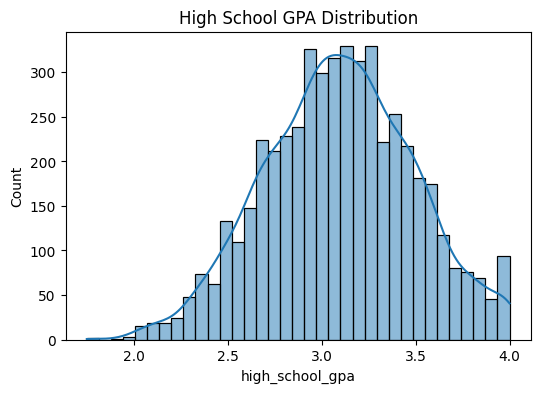

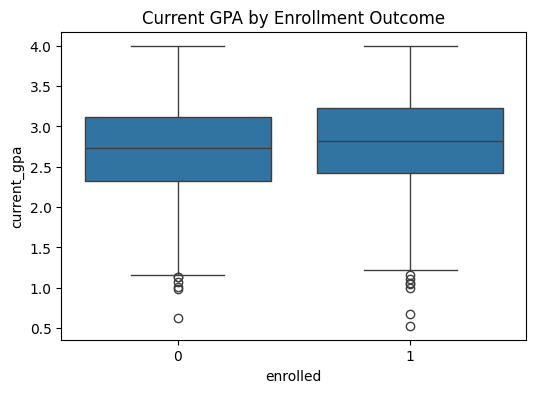

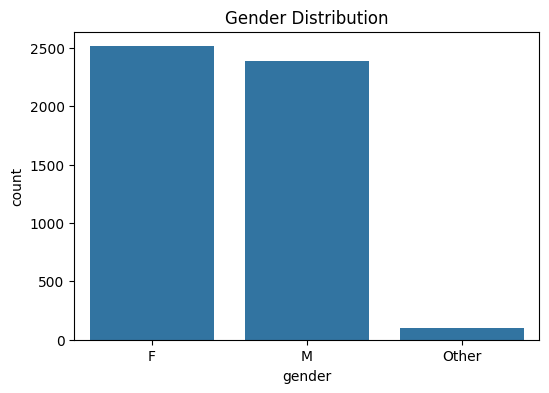

Train/Test sizes: (4000, 13) (1000, 13)

Training Logistic Regression...
Training Random Forest...
Training XGBoost...

Logistic Regression AUC: 0.6027  AP: 0.7619
              precision    recall  f1-score   support

           0       0.47      0.08      0.13       304
           1       0.70      0.96      0.81       696

    accuracy                           0.69      1000
   macro avg       0.59      0.52      0.47      1000
weighted avg       0.63      0.69      0.61      1000



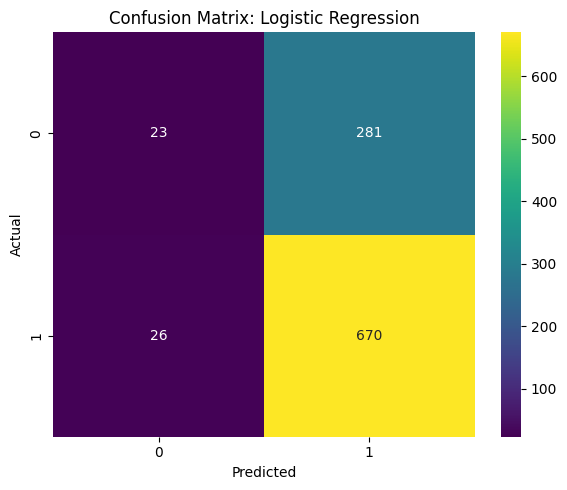


Random Forest AUC: 0.5794  AP: 0.7485
              precision    recall  f1-score   support

           0       0.41      0.06      0.11       304
           1       0.70      0.96      0.81       696

    accuracy                           0.69      1000
   macro avg       0.56      0.51      0.46      1000
weighted avg       0.61      0.69      0.60      1000



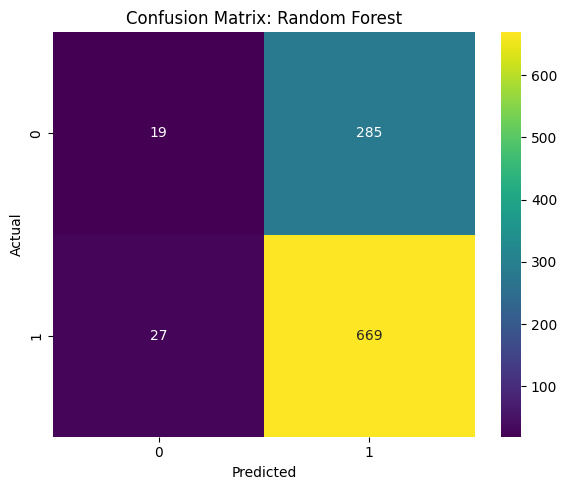


XGBoost AUC: 0.5463  AP: 0.7441
              precision    recall  f1-score   support

           0       0.36      0.20      0.26       304
           1       0.71      0.84      0.77       696

    accuracy                           0.65      1000
   macro avg       0.53      0.52      0.51      1000
weighted avg       0.60      0.65      0.61      1000



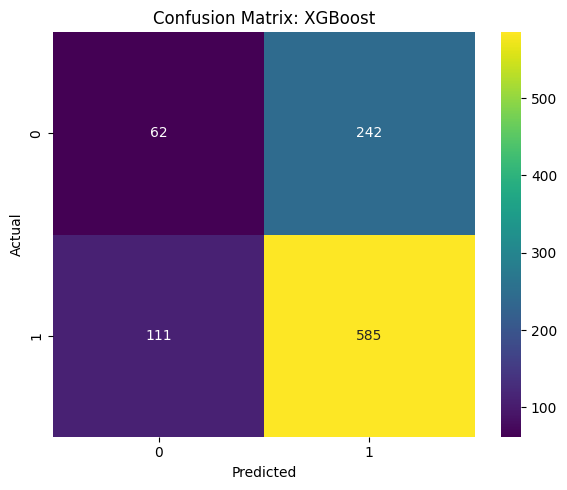

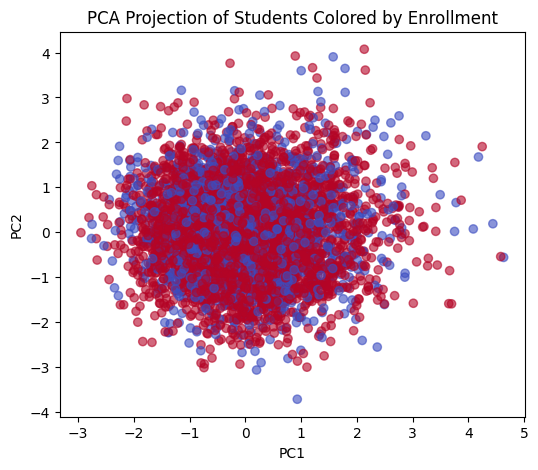

Saved model + predictions.


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import joblib
import sklearn
from sklearn.decomposition import PCA


DATA_FILE = 'students.csv'
np.random.seed(42)

if os.path.exists(DATA_FILE):
    df = pd.read_csv(DATA_FILE)
    print(f"Loaded {DATA_FILE} with shape {df.shape}")

else:
    n = 5000
    df = pd.DataFrame({
        'student_id': np.arange(n),
        'age': np.random.randint(17, 45, size=n),
        'gender': np.random.choice(['M', 'F', 'Other'], size=n, p=[0.48,0.50,0.02]),
        'ethnicity': np.random.choice(['GroupA','GroupB','GroupC','GroupD'], size=n),
        'high_school_gpa': np.round(np.random.normal(3.1, 0.4, size=n).clip(0,4),2),
        'sat_score': np.round(np.random.normal(1050, 120, size=n)).astype(int),
        'num_prior_colleges': np.random.poisson(0.2, size=n),
        'credits_earned': np.round(np.random.normal(20, 15, size=n).clip(0)),
        'current_gpa': np.round(np.random.normal(2.8, 0.6, size=n).clip(0,4),2),
        'attendance_rate': np.round(np.random.beta(8,2,size=n),2),
        'financial_aid': np.random.choice(['yes','no'], size=n, p=[0.55,0.45]),
        'first_generation': np.random.choice(['yes','no'], size=n, p=[0.3,0.7]),
        'distance_to_campus_km': np.round(np.random.exponential(5, size=n),1),
        'applied_program': np.random.choice(['CS','Business','Arts','Engineering','Health'], size=n),
    })

    # Enrollment probability
    logits = (
        0.8*(df['high_school_gpa']-2.5) +
        0.002*(df['sat_score']-1000) +
        -0.02*(df['distance_to_campus_km']) +
        0.5*(df['financial_aid']=='yes').astype(int) +
        0.4*(df['current_gpa']-2.0)
    )
    prob = 1/(1+np.exp(-logits/1.2))
    df['enrolled'] = (np.random.rand(n) < prob).astype(int)

    # Graduation probability
    grad_logits = 0.6*(df['current_gpa']-2.0) + 0.3*(df['attendance_rate']-0.6) - 0.2*(df['num_prior_colleges'])
    grad_prob = 1/(1+np.exp(-grad_logits))
    df['graduated_within_6yrs'] = (np.random.rand(n) < grad_prob).astype(int)

    print("Generated synthetic data:", df.shape)


print(df.head())
print("\nShape:", df.shape)
print("\nMissing values per column:\n", df.isnull().sum())


plt.figure(figsize=(6,4))
sns.histplot(df['high_school_gpa'], kde=True)
plt.title("High School GPA Distribution")
plt.show()

plt.figure(figsize=(6,4))
sns.boxplot(x='enrolled', y='current_gpa', data=df)
plt.title("Current GPA by Enrollment Outcome")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='gender', data=df)
plt.title("Gender Distribution")
plt.show()



features = [c for c in df.columns if c not in ['student_id', 'enrolled', 'graduated_within_6yrs']]
numeric_features = df[features].select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = [c for c in features if c not in numeric_features]

if int(sklearn.__version__.split('.')[1]) >= 2:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
else:
    onehot = OneHotEncoder(handle_unknown='ignore', sparse=False)

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', onehot)
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])


X = df[features]
y = df['enrolled']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=42
)

print("Train/Test sizes:", X_train.shape, X_test.shape)


lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=200, random_state=42))
])

xgb_pipeline = Pipeline([
    ('pre', preprocessor),
    ('clf', xgb.XGBClassifier(
        random_state=42,
        verbosity=0,
        eval_metric='logloss'
    ))
])

print("\nTraining Logistic Regression...")
lr_pipeline.fit(X_train, y_train)

print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training XGBoost...")
xgb_pipeline.fit(X_train, y_train)


def evaluate_model(pipeline, X_test, y_test, name="model"):
    probs = pipeline.predict_proba(X_test)[:,1]
    preds = (probs >= 0.5).astype(int)

    auc = roc_auc_score(y_test, probs)
    ap = average_precision_score(y_test, probs)

    print(f"\n{name} AUC: {auc:.4f}  AP: {ap:.4f}")
    print(classification_report(y_test, preds))

    # Confusion matrix
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title(f"Confusion Matrix: {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    return {"auc": auc, "ap": ap}


# Evaluate all models
res_lr = evaluate_model(lr_pipeline, X_test, y_test, "Logistic Regression")
res_rf = evaluate_model(rf_pipeline, X_test, y_test, "Random Forest")
res_xgb = evaluate_model(xgb_pipeline, X_test, y_test, "XGBoost")


X_proc = preprocessor.fit_transform(df[features])
pca = PCA(n_components=2)
coords = pca.fit_transform(X_proc)

plt.figure(figsize=(6,5))
plt.scatter(coords[:,0], coords[:,1], c=df['enrolled'], cmap='coolwarm', alpha=0.6)
plt.title("PCA Projection of Students Colored by Enrollment")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()



joblib.dump(xgb_pipeline, 'xgb_pipeline.joblib')

pred_df = pd.DataFrame({
    'student_id': X_test.index,
    'enroll_prob': xgb_pipeline.predict_proba(X_test)[:,1]
})
pred_df.to_csv("enrollment_predictions_testset.csv", index=False)

print("Saved model + predictions.")
